# Analysis of the ABIDE dataset

### Imports

In [9]:
import warnings
import os
from os.path import join
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import r2_score, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from nilearn.datasets.utils import _uncompress_file, _fetch_file
from nilearn.connectome import ConnectivityMeasure

from neurocombat_sklearn import CombatModel

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.formula.api import ols as ols_f
from statsmodels.formula.api import mnlogit as logit_f

from mlxtend.evaluate import permutation_test
#!pip install git+https://github.com/pni-lab/mlconfound --upgrade
#from importlib import reload
import mlconfound
from mlconfound.stats import test_fully_confounded, test_partially_confounded
from mlconfound.plot import plot_graph
#reload(mlconfound.stats)

## Load data

In [10]:
data_dir = '../data_in/ABIDE'

url = 'https://osf.io/hc4md/download'

# Download the zip file, first
dl_file = _fetch_file(url, data_dir=data_dir)

# Second, uncompress the downloaded zip file
_uncompress_file(dl_file, verbose=2)


Downloaded 1807450112 of 1811491701 bytes (99.8%,    0.7s remaining) ...done. (300 seconds, 5 min)
Extracting data from ../data_in/ABIDE/download..... done.


In [11]:
def _get_paths(phenotypic, atlas, timeseries_dir):
    """
    """
    timeseries = []
    IDs_subject = []
    diagnosis = []
    subject_ids = phenotypic['SUB_ID']
    mean_fd = []
    num_fd = []
    perc_fd = []
    site = []
    for index, subject_id in enumerate(subject_ids):
        this_pheno = phenotypic[phenotypic['SUB_ID'] == subject_id]
        this_timeseries = join(timeseries_dir, atlas,
                               str(subject_id) + '_timeseries.txt')
        if os.path.exists(this_timeseries):
            timeseries.append(np.loadtxt(this_timeseries))
            IDs_subject.append(subject_id)
            diagnosis.append(this_pheno['DX_GROUP'].values[0])
            mean_fd.append(this_pheno['func_mean_fd'].values[0])
            num_fd.append(this_pheno['func_num_fd'].values[0])
            perc_fd.append(this_pheno['func_perc_fd'].values[0])
            site.append(this_pheno['SITE_ID'].values[0])
    return timeseries, diagnosis, IDs_subject, mean_fd, num_fd, perc_fd, site

Download the phenotypic summary information file form the preprocessed connectomes project.
- First read:
  http://preprocessed-connectomes-project.org/abide/download.html
- Then download:
  https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv
- Copy the csv file into the data_in/ABIDE directory

In [12]:
phenotypic = pd.read_csv('../data_in/ABIDE/Phenotypic_V1_0b_preprocessed1.csv').iloc[:,2:]
timeseries, diagnosis, IDs_subject, mean_fd, num_fd, perc_fd, site = _get_paths(phenotypic, "BASC/regions", '../data_in/ABIDE/')
sites, site_int = np.unique(site, return_inverse=True)
phenotypic
    

,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,50002,1,50002,PITT,no_filename,1,1,16.77,1,Ambi,...,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,2,R,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,1,L,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,51583,1108,51583,SBL,SBL_0051583,1,2,35.00,1,NaN,...,NaN,OK,NaN,OK,ic-cerebellum-temporal_lobe,OK,NaN,OK,NaN,0
1108,51584,1109,51584,SBL,SBL_0051584,1,2,49.00,1,NaN,...,NaN,OK,NaN,maybe,vmpfc dropout,OK,NaN,OK,NaN,0
1109,51585,1110,51585,SBL,SBL_0051585,1,1,27.00,1,NaN,...,NaN,OK,NaN,maybe,ic-cerebellum-temporal_lobe,OK,NaN,OK,NaN,0
1110,51606,1111,51606,MAX_MUN,MaxMun_a_0051606,1,2,29.00,2,R,...,NaN,OK,NaN,maybe,ic-cerebellum,OK,NaN,OK,NaN,0


FileNotFoundError: [Errno 2] No such file or directory: '../data_out/fig/abide_motion_hist.pdf'

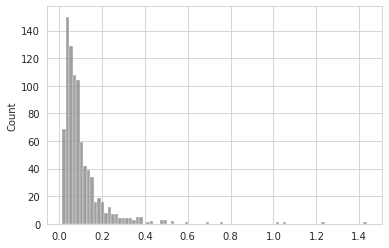

In [13]:
sns.histplot(mean_fd, color='gray')
plt.savefig('../data_out/fig/abide_motion_hist.pdf')
kurtosis(mean_fd), skew(mean_fd)

In [ ]:
sns.histplot(np.log(mean_fd), color='gray')
kurtosis(np.log(mean_fd)), skew(np.log(mean_fd))

In [ ]:
rng = np.random.default_rng(42)
mean_fd_trf = quantile_transform(np.array([mean_fd]).T, output_distribution='normal',
                                 n_quantiles=len(mean_fd)).flatten()

sns.histplot(mean_fd_trf, color='gray')
plt.savefig('../data_out/fig/abide_motion_quanttrf_hist.pdf')

kurtosis(mean_fd_trf), skew(mean_fd_trf)
mean_fd = mean_fd_trf


## Binning motion data (to be used later)

In [ ]:
# binning mean_fd
bins = 10 # approximately 80 subject per motion group

limits = np.quantile(mean_fd, np.arange(0, 1, 1/bins))
mean_fd_binned = np.digitize(mean_fd, limits)

## Calculate connectivity

In [ ]:
connections = ConnectivityMeasure(kind='tangent', vectorize=True, discard_diagonal=True)
conn_coefs = connections.fit_transform(timeseries)

In [ ]:
_, y = np.unique(diagnosis, return_inverse=True)
X = conn_coefs

# Machine learning (raw)

In [ ]:
outer_cv = StratifiedKFold(10)
inner_cv = StratifiedKFold(10) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    ('model', LogisticRegression())])

p_grid = {'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    clf.fit(X[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X[test])
    predicted_prob[test] = clf.predict_proba(X[test])[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1

In [ ]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
plt.savefig('../data_out/fig/abide_raw_rocplot.pdf')


In [ ]:
plt.figure(figsize=(5,1.5))

pal=[sns.color_palette("coolwarm", 10)[0], sns.color_palette("coolwarm", 10)[-1]]
sns.stripplot(x=site, y=predicted_prob, hue=y, palette=pal, alpha=0.2, jitter=0.2, dodge=True)
ax=sns.boxplot(x=site, y=predicted_prob, hue=y, showfliers = False)
for box in ax.artists:
    box.set_facecolor((1,1,1,0))
plt.xticks(rotation=90)
for i in range(len(np.unique(site))):
    plt.axvline(i+0.5, color="gray", alpha=0.5, linewidth=0.5)
plt.savefig('../data_out/fig/abide_site_raw_striplot.pdf')

In [ ]:
plt.figure(figsize=(5,2))
sns.stripplot(x=y, y=predicted_prob, hue=mean_fd_binned,
              palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=y, y=predicted_prob, color=(1,1,1,1))
plt.legend([],[], frameon=False)
plt.savefig('../data_out/fig/abide_motion_raw_stripplot.pdf')

In [ ]:
plot_graph(test_partially_confounded(y, predicted, mean_fd, random_state=42),
          outfile_base='../data_out/fig/abide_motion_raw_partial')

In [ ]:
plot_graph(test_fully_confounded(y, predicted, mean_fd, random_state=42),
          outfile_base='../data_out/fig/abide_motion_raw_full')

In [ ]:
plot_graph(test_partially_confounded(y, predicted, site_int, cat_c=True, random_state=42),
          outfile_base='../data_out/fig/abide_site_raw_partial')

In [ ]:
plot_graph(test_fully_confounded(y, predicted, site_int, cat_c=True, random_state=42),
          outfile_base='../data_out/fig/abide_site_raw_full')

# Regress out motion from the features

In [ ]:
# regress-out motion from connectivity
X_adj = np.zeros_like(X)
for i in range(X.shape[1]):
    OLS_model = OLS(X[:,i], sm.add_constant(mean_fd)).fit()  # training the model
    X_adj[:, i] = OLS_model.resid

In [ ]:
outer_cv = StratifiedKFold(10)
inner_cv = StratifiedKFold(10) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', LogisticRegression())])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    clf.fit(X_adj[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_adj[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_adj[test])
    predicted_prob[test] = clf.predict_proba(X_adj[test])[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_adj[test], y[test])
    i = i+1

In [ ]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
plt.savefig('../data_out/fig/abide_motion_reg_rocplot.pdf')
    

In [ ]:
plt.figure(figsize=(5,2))
sns.stripplot(x=y, y=predicted_prob, hue=mean_fd_binned,
              palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=y, y=predicted_prob, color=(1,1,1,1))
plt.legend([],[], frameon=False)
plt.savefig('../data_out/fig/abide_motion_reg_stripplot.pdf')

In [ ]:
plot_graph(test_partially_confounded(y, predicted, mean_fd, random_state=42),
          outfile_base='../data_out/fig/abide_motion_reg_partial')

In [ ]:
plot_graph(test_fully_confounded(y, predicted, mean_fd, random_state=42),
          outfile_base='../data_out/fig/abide_motion_reg_full')

# Regress out site

In [ ]:
# regress-out acquisition from connectivity
X_adj = np.zeros_like(X)
for i in range(X.shape[1]):
    tmp = pd.DataFrame({
        'x': site_int,
        'y': X[:,i]
    })
    OLS_model = ols_f("y ~ C(x)", tmp).fit()  # training the model
    X_adj[:, i] = OLS_model.resid.values

In [ ]:
outer_cv = StratifiedKFold(10)
inner_cv = StratifiedKFold(10) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', LogisticRegression())])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    clf.fit(X_adj[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_adj[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_adj[test])
    predicted_prob[test] = clf.predict_proba(X_adj[test])[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_adj[test], y[test])
    i = i+1

In [ ]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
plt.savefig('../data_out/fig/abide_site_reg_rocplot.pdf')
    

In [ ]:
plt.figure(figsize=(5,1.5))

pal=[sns.color_palette("coolwarm", 10)[0], sns.color_palette("coolwarm", 10)[-1]]
sns.stripplot(x=site, y=predicted_prob, hue=y, palette=pal, alpha=0.2, jitter=0.2, dodge=True)
ax=sns.boxplot(x=site, y=predicted_prob, hue=y, showfliers = False)
for box in ax.artists:
    box.set_facecolor((1,1,1,0))
plt.xticks(rotation=90)
for i in range(len(np.unique(site))):
    plt.axvline(i+0.5, color="gray", alpha=0.5, linewidth=0.5)
plt.savefig('../data_out/fig/abide_site_reg_striplot.pdf')

In [ ]:
plot_graph(test_partially_confounded(y, predicted, site_int, cat_c=True, random_state=42),
          outfile_base='../data_out/fig/abide_site_reg_partial')

In [ ]:
plot_graph(test_fully_confounded(y, predicted, site_int, cat_c=True, random_state=42),
          outfile_base='../data_out/fig/abide_site_reg_full')

# Combat on binned motion data

In [ ]:
outer_cv = StratifiedKFold(10)
inner_cv = StratifiedKFold(10) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', LogisticRegression())])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):
    
    comb = CombatModel()
    X_train_combat = comb.fit_transform(X[:,np.sum(X,0)!=0][train],
                                   np.array([mean_fd_binned[train]]).transpose()
                                  )


    clf.fit(X_train_combat, y[train])
    
    X_test_combat = comb.transform(X[:,np.sum(X,0)!=0][test],
                                   np.array([mean_fd_binned[test]]).transpose())

                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_test_combat, y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_test_combat)
    predicted_prob[test] = clf.predict_proba(X_test_combat)[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_test_combat, y[test])
    i = i+1

In [ ]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
plt.savefig('../data_out/fig/abide_motion_comb_rocplot.pdf')  
    

In [ ]:
plt.figure(figsize=(5,2))
sns.stripplot(x=y, y=predicted_prob, hue=mean_fd_binned,
              palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
plt.legend([],[], frameon=False)
sns.boxplot(x=y, y=predicted_prob, color=(1,1,1,1))
plt.savefig('../data_out/fig/abide_motion_comb_stripplot.pdf')

In [ ]:
plot_graph(test_partially_confounded(y, predicted, mean_fd, random_state=42),
          outfile_base='../data_out/fig/abide_motion_comb_partial')

In [ ]:
plot_graph(test_fully_confounded(y, predicted, mean_fd, random_state=42),
          outfile_base='../data_out/fig/abide_motion_comb_full')

# Combat on site

In [ ]:
outer_cv = StratifiedKFold(10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(10, shuffle=True, random_state=42) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', LogisticRegression())])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):
    
    comb = CombatModel()
    X_train_combat = comb.fit_transform(X[:,np.sum(X,0)!=0][train],
                                   np.array([site_int[train]]).transpose()
                                  )


    clf.fit(X_train_combat, y[train])
    
    X_test_combat = comb.transform(X[:,np.sum(X,0)!=0][test],
                                   np.array([site_int[test]]).transpose())

                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_test_combat, y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_test_combat)
    predicted_prob[test] = clf.predict_proba(X_test_combat)[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_test_combat, y[test])
    i = i+1

In [ ]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
plt.savefig('../data_out/fig/abide_site_comb_rocplot.pdf')  

In [ ]:
plt.figure(figsize=(5,1.5))

pal=[sns.color_palette("coolwarm", 10)[0], sns.color_palette("coolwarm", 10)[-1]]
sns.stripplot(x=site, y=predicted_prob, hue=y, palette=pal, alpha=0.2, jitter=0.2, dodge=True)
ax=sns.boxplot(x=site, y=predicted_prob, hue=y, showfliers = False)
for box in ax.artists:
    box.set_facecolor((1,1,1,0))
plt.xticks(rotation=90)
for i in range(len(np.unique(site))):
    plt.axvline(i+0.5, color="gray", alpha=0.5, linewidth=0.5)
plt.savefig('../data_out/fig/abide_site_comb_striplot.pdf')

In [ ]:
plot_graph(test_partially_confounded(y, predicted, site_int, cat_c=True, random_state=42),
          outfile_base='../data_out/fig/abide_site_comb_partial')

In [ ]:
plot_graph(test_fully_confounded(y, predicted, site_int, cat_c=True, random_state=42),
          outfile_base='../data_out/fig/abide_site_comb_full')

In [ ]:
sns.color_palette("coolwarm", as_cmap=True)

In [ ]:
np.max(mean_fd)

In [ ]:
def workhorse(x, y):
    df = pd.DataFrame({
        'x': x,
        'y': y
    })
    fit = logit_f('C(y) ~ x', data=df).fit(disp=0)
    return fit.prsquared

permutation_test(mean_fd, y,
                 func=workhorse,
                 method='approximate',
                 num_rounds=1000,
                 seed=42)

In [ ]:
def workhorse(x, y):
    df_tmp=pd.DataFrame({
        'x': site_int.astype(float),
        'y': y.astype(int)
    })
    df_tmp.x = pd.to_numeric(df_tmp.x)
    df_tmp.y = pd.to_numeric(df_tmp.y)
    fit = logit_f('y ~ C(x)', data=df_tmp).fit(disp=0)
    return fit.prsquared

permutation_test(site_int, y,
                 func=workhorse,
                 method='approximate',
                 num_rounds=1,
                 seed=42)

In [ ]:
df_tmp=pd.DataFrame({
            'x': np.random.permutation(site_int).astype(int),
            'y': y.astype(int)
        })
fit = logit_f('y ~ C(x)', data=df_tmp).fit(disp=0)
unpermuted = fit.prsquared

nulldist=[]
for i in range(1000):
    
    df_tmp=pd.DataFrame({
            'x': np.random.permutation(site_int).astype(int),
            'y': y.astype(int)
        })
    fit = logit_f('y ~ C(x)', data=df_tmp).fit(disp=0)
    nulldist.append(fit.prsquared)
(nulldist <= unpermuted).sum()/len(nulldist)

In [ ]:
df_tmp=pd.DataFrame({
            'x': np.random.permutation(mean_fd).astype(float),
            'y': y.astype(int)
        })
df_tmp.x = pd.to_numeric(df_tmp.x)
df_tmp.y = pd.to_numeric(df_tmp.y)
fit = logit_f('y ~ x', data=df_tmp).fit(disp=0)
unpermuted = fit.prsquared

nulldist=[]
for i in range(1000):
    
    df_tmp=pd.DataFrame({
            'x': np.random.permutation(mean_fd).astype(int),
            'y': y.astype(int)
        })
    df_tmp.x = pd.to_numeric(df_tmp.x)
    df_tmp.y = pd.to_numeric(df_tmp.y)
    fit = logit_f('y ~ x', data=df_tmp).fit(disp=0)
    nulldist.append(fit.prsquared)
(nulldist <= unpermuted).sum()/len(nulldist)

In [ ]:
unpermuted